In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.corpus import wordnet
import nltk #for stemming process
from nltk.stem.porter import PorterStemmer
from surprise import Reader, Dataset, SVD , BaselineOnly, KNNBasic
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import pickle

import warnings; warnings.simplefilter('ignore')

In [2]:
movies_list = pickle.load(open('movie_list.pkl','rb'))

In [3]:
movies_list

,movieId,vote_count,vote_average,Title,tag
0,1,50580,3.880921,Toy Story,"3d,action,adventure,affectionate,animal movie,..."
1,2,24376,3.216832,Jumanji,"action,action packed,adaptation,adapted from:b..."
2,3,9479,3.086560,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scener..."
3,4,2603,2.831733,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acti..."
4,5,9520,3.011029,Father of the Bride Part II,"adaptation,bad plot,bad sequel,betrayal,better..."
...,...,...,...,...,...
10809,185135,209,4.244019,Sherlock - A Study in Pink,"action,based on a book,beautiful scenery,briti..."
10810,185585,300,2.801667,Pacific Rim: Uprising,"action,adaptation,adventure,allegory,bad actin..."
10811,186587,204,2.950980,Rampage,"action,adapted from:comic,aliens,allegory,anim..."
10812,187593,1350,3.819259,Deadpool 2,"absurd,action,adaptation,anti-hero,betrayal,be..."


# Content Based 

In [7]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_list['tag'])

In [8]:
tfidf_matrix.shape

(10814, 25602)

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. We will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [9]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
cosine_sim[0]

array([1.        , 0.22798059, 0.14492483, ..., 0.06895145, 0.11689302,
       0.18314983])

In [11]:
movies_list = movies_list.reset_index()
titles = movies_list['Title']
indices = pd.Series(movies_list.index, index=movies_list['Title'])

In [12]:
def get_recommendations(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n+1)]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Check for some recommmendations

In [13]:
get_recommendations('Toy Story',5)

2668       Toy Story 2
4111    Monsters, Inc.
1986      A Bug's Life
4351           Ice Age
7548       Ratatouille
Name: Title, dtype: object

In [14]:
get_recommendations('The Shawshank Redemption',5)

2696         The Green Mile
332            Forrest Gump
1065     Dead Poets Society
1447      Good Will Hunting
6756    Million Dollar Baby
Name: Title, dtype: object

In [15]:
get_recommendations('His Girl Friday',5)

825           Bringing Up Baby
2509              The Lady Eve
5011           The Awful Truth
768     The Philadelphia Story
817             My Man Godfrey
Name: Title, dtype: object

In [16]:
get_recommendations('The Dark Knight',10)

6972                              Batman Begins
9164                      The Dark Knight Rises
9434    Batman: The Dark Knight Returns, Part 1
547                                      Batman
9120                           Batman: Year One
1185                             Batman Returns
9481    Batman: The Dark Knight Returns, Part 2
6629                  The Batman/Superman Movie
8726                 Batman: Under the Red Hood
2749               Batman: Mask of the Phantasm
Name: Title, dtype: object

We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations.
We are going to use much more suggestive metadata than Overview and Tagline.

### first improvement: use tags with stemming

In [14]:
ps = PorterStemmer()

#defining the stemming function
def stem(text):
    y=[]
    
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)


In [15]:
movies_list['tag'] = movies_list['tag'].apply(stem) #appplying stemming process on tags column

In [16]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(movies_list['tag'])

In [17]:
cosine_sim = linear_kernel(count_matrix, count_matrix)

In [18]:
pickle.dump(cosine_sim,open('contend_cosine_sim.pkl','wb'))

In [19]:
pickle.dump(count_matrix,open('contend_matrix.pkl','wb'))

In [17]:
count_matrix = pickle.load(open('contend_matrix.pkl','rb'))

In [18]:
cosine_sim = pickle.load(open('contend_cosine_sim.pkl','rb'))

Let us check for The Dark Knight again.

In [19]:
get_recommendations('The Dark Knight',10)

9164                    The Dark Knight Rises
1859                         The Untouchables
6972                            Batman Begins
7423                             The Departed
3034                                Gladiator
8850                                True Grit
4828    The Lord of the Rings: The Two Towers
1626                                    Rocky
8355                          The Hurt Locker
1034                               Goodfellas
Name: Title, dtype: object

In [20]:
get_recommendations('Toy Story',5)

2668                       Toy Story 2
4111                    Monsters, Inc.
8928    Winnie the Pooh and Tigger Too
340                      The Lion King
9329                       Geri's Game
Name: Title, dtype: object

### second improvement : Add Popularity and Ratings
We notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight.

So We will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

We will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of , we will calculate the weighted rating of each movie using IMDB's formula 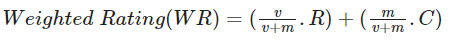 

where,

    v is the number of votes for the movie
    
    m is the minimum votes required to be listed in the chart
    
    R is the average rating of the movie
    
    C is the mean vote across the whole report

In [21]:
movie_rating = pickle.load(open('movie_list.pkl','rb'))
movie_rating

,movieId,vote_count,vote_average,Title,tag
0,1,50580,3.880921,Toy Story,"3d,action,adventure,affectionate,animal movie,..."
1,2,24376,3.216832,Jumanji,"action,action packed,adaptation,adapted from:b..."
2,3,9479,3.086560,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scener..."
3,4,2603,2.831733,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acti..."
4,5,9520,3.011029,Father of the Bride Part II,"adaptation,bad plot,bad sequel,betrayal,better..."
...,...,...,...,...,...
10809,185135,209,4.244019,Sherlock - A Study in Pink,"action,based on a book,beautiful scenery,briti..."
10810,185585,300,2.801667,Pacific Rim: Uprising,"action,adaptation,adventure,allegory,bad actin..."
10811,186587,204,2.950980,Rampage,"action,adapted from:comic,aliens,allegory,anim..."
10812,187593,1350,3.819259,Deadpool 2,"absurd,action,adaptation,anti-hero,betrayal,be..."


In [22]:
#movies = movie_rating.iloc[movie_indices][['Title', 'vote_count', 'vote_average']]
vote_counts = movie_rating[movie_rating['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movie_rating[movie_rating['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
# We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [23]:
def weighted_rating(x):
    
    v = x['vote_count']
    R = x['vote_average']
  
    return (v/(v+m) * R) + (m/(m+v) * C)

In [24]:
def improved_recommendations(title, n=5):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movie_rating.iloc[movie_indices][['Title', 'vote_count', 'vote_average']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(n)
    return qualified

In [25]:
improved_recommendations('The Dark Knight',10)

,Title,vote_count,vote_average,wr
332,Forrest Gump,69235,4,3.839144
295,The Shawshank Redemption,64938,4,3.829966
493,Schindler's List,51657,4,3.793564
4195,The Lord of the Rings: The Fellowship of the Ring,49204,4,3.785064
741,The Godfather,45375,4,3.770303
4828,The Lord of the Rings: The Two Towers,45258,4,3.769820
5612,The Lord of the Rings: The Return of the King,43816,4,3.763695
1700,Saving Private Ryan,43685,4,3.763123
1034,Goodfellas,31185,4,3.691881
3034,Gladiator,42087,3,2.953706


In [26]:
improved_recommendations('Reservoir Dogs', 5)

,Title,vote_count,vote_average,wr
274,Pulp Fiction,67230,4,3.834988
47,The Usual Suspects,49328,4,3.785511
1034,Goodfellas,31185,4,3.691881
3408,Snatch,24315,4,3.630865
7423,The Departed,22968,4,3.615954


In [27]:
improved_recommendations('Toy Story', 5)

,Title,vote_count,vote_average,wr
332,Forrest Gump,69235,4,3.839144
1447,Good Will Hunting,36617,4,3.727496
340,The Lion King,39753,3,2.951550
5095,Finding Nemo,33031,3,2.944048
4111,"Monsters, Inc.",32549,3,2.943419


# Colloborative Filtering


Content based engine suffers from some severe limitations.

* It is only capable of suggesting movies which are close to a certain movie.
* It is not really personal in that it doesn't capture the personal tastes and biases of a user.

 So, we will use Collaborative Filtering to make recommendations to capture personal tastes. 
 
 We will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) and baseline Algorithm to minimise RMSE (Root Mean Square Error). We will compare them and decide to useful one.

In [28]:
datam = pd.read_csv('clean_rating_colloborative_filter.csv')

In [29]:
datam

,userId,movieId,rating
0,4,1,4.0
1,4,2,4.0
2,4,5,2.0
3,4,6,4.5
4,4,10,4.0
...,...,...,...
24010726,283228,8542,4.5
24010727,283228,8712,4.5
24010728,283228,34405,4.5
24010729,283228,44761,4.5


In [42]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(datam[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Use SVD algorithm or other models
svd = SVD()

In [ ]:
# cross-validation with no. of kfold=5 (can be changed per your need)
cross_validate(svd, data, measures=['rmse', 'mae'], cv=5)

In [ ]:
# Use baselinonly algorithm or other models
blo = BaselineOnly()

In [ ]:
# cross-validation with no. of kfold=5 (can be changed per your need)
cross_validate(blo, data, measures=['rmse', 'mae'], cv=5)

We compared SVD and Baselineonly models. SVD gave us better rmse's. So we are going to go with SVD. 

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [30]:
ratings = pickle.load(open('movies_data.pkl','rb'))

In [31]:
ratings

,movieId,Title,tag,userId,rating
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",4,4.0
1,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",10,5.0
2,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",14,4.5
3,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",15,4.0
4,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",31,5.0
...,...,...,...,...,...
24006711,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",279746,3.0
24006712,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",280404,4.5
24006713,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",281688,4.0
24006714,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",282475,4.5


In [32]:
rating_d = ratings.userId.unique()

In [33]:
rating_dict = dict(enumerate(rating_d.flatten(), 1))

In [35]:
pickle.dump(rating_dict,open('rating_dict.pkl','wb'))

In [36]:
ratings[ratings['userId'] == 5]

,movieId,Title,tag,userId,rating
487495,47,Seven,"alternate endings,atmospheric,bad ending,bleak...",5,4.0
547641,50,The Usual Suspects,"action,alternate endings,amazing photography,a...",5,5.0
1778625,293,Léon: The Professional,"action,action packed,affectionate,anti-hero,as...",5,3.5
1812419,296,Pulp Fiction,"artistic,artsy,atmospheric,awesome soundtrack,...",5,5.0
1988650,318,The Shawshank Redemption,"adapted from:book,atmospheric,awesome,based on...",5,5.0
...,...,...,...,...,...
20669447,55290,Gone Baby Gone,"adaptation,adapted from:book,assassination,bas...",5,4.0
20687744,55765,American Gangster,"1970s,action,addiction,anti-hero,assassination...",5,4.0
20700987,55820,No Country for Old Men,"adaptation,adapted from:book,allegory,amazing ...",5,4.5
20765177,56367,Juno,"abortion,adolescence,adoption,affectionate,awe...",5,5.0


In [ ]:
pickle.dump(svd,open('colloborative_SVD_model.pkl','wb'))

In [34]:
svd = pickle.load(open('colloborative_SVD_model.pkl','rb'))

In [35]:
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=3.7322267252884367, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 3.7322. One startling feature of this recommender system is that it doesn't care what the movie is. It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have perceive the movie.

In [36]:
ratings = pickle.load(open('movies_data.pkl','rb'))
ratings

,movieId,Title,tag,userId,rating
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",4,4.0
1,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",10,5.0
2,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",14,4.5
3,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",15,4.0
4,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...",31,5.0
...,...,...,...,...,...
24006711,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",279746,3.0
24006712,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",280404,4.5
24006713,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",281688,4.0
24006714,187595,Solo: A Star Wars Story,"action,adaptation,adapted from:book,adventure,...",282475,4.5


Let’s make our recommendations to a particular user. Let’s focus on uid 4 and find one item to recommend them. First we need to find the movie ids that user 4 didn’t rate.

In [37]:
def user_based_recommendation(user_id, n=5):
    iids = ratings['movieId'].unique()
    iids_user = ratings.loc[ratings['userId']==user_id,'movieId']
    iids_to_pred = np.setdiff1d(iids,iids_user)
    
    testset = [[user_id, iid, 4.0] for iid in iids_to_pred]
    predictions = svd.test(testset)
    
    pred_ratings = np.array([pred.est for pred in predictions])
    i_top_n = pred_ratings.argsort()[-n:][::-1]

    iids_topn = iids_to_pred[i_top_n]

    """films = []
    for i in iids_topn:
        films.append(ratings[ratings['movieId']==i][:1]['Title'].values[0])   
    return films"""
    rec_films = pd.DataFrame()
    for i in iids_topn:
        rec_films = rec_films.append(ratings[ratings['movieId']==i][:1])   
    return rec_films

Next we want to predict the score of each of the movie ids that user 4 didn’t rate, and find the best one. For this we have to create another dataset with the iids we want to predict in the sparse format as before of: uid, iid, rating. We'll just arbitrarily set all the ratings of this test set to 4, as they are not needed.

In [38]:
user_based_recommendation(4)

,movieId,Title,tag,userId,rating
23944555,170705,Band of Brothers,"adapted from:book,amazing photography,based on...",471,4.0
20891622,58559,The Dark Knight,"action,action packed,adaptation,adapted from:c...",14,5.0
19638336,40697,Babylon 5,"adapted from:book,affectionate,alien,aliens,al...",3846,4.0
22858879,99813,"Batman: The Dark Knight Returns, Part 2","action,action packed,adaptation,alter ego,anim...",471,1.5
20951943,59315,Iron Man,"action,action packed,adaptation,adapted from:c...",14,4.0


In [39]:
user_based_recommendation(697)

,movieId,Title,tag,userId,rating
23987655,179135,Blue Planet II,"1980s,adapted from:book,adolescence,affectiona...",214,5.0
10560146,2360,The Celebration,"art,art house,artistic,atmospheric,black comed...",10,5.0
23483788,118930,Bill Burr: I'm Sorry You Feel That Way,"adapted from:book,adultery,amazing photography...",1073,5.0
5787257,1173,The Cook the Thief His Wife & Her Lover,"absurd,adaptation,adapted from:book,adultery,a...",214,4.0
3154063,501,Naked,"absurd,adaptation,addiction,allegory,anti-hero...",10,4.0


In [40]:
user_based_recommendation(14)

,movieId,Title,tag,userId,rating
23948673,171011,Planet Earth II,"affectionate,amazing photography,animals,art,a...",697,4.5
23987655,179135,Blue Planet II,"1980s,adapted from:book,adolescence,affectiona...",214,5.0
23838413,159817,Planet Earth,"adapted from:book,affectionate,amazing cinemat...",75,3.0
23953977,172577,Last Year's Snow Was Falling,"adaptation,affectionate,amazing photography,an...",339,5.0
23945853,170777,There Once Was a Dog,"adaptation,adapted from:book,affectionate,anim...",248,4.0


### testing SVD model 

In [43]:
import surprise
output = surprise.model_selection.cross_validate(svd, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7639  0.7641  0.7641  0.7640  0.7632  0.7638  0.0003  
MAE (testset)     0.5781  0.5785  0.5785  0.5785  0.5780  0.5783  0.0002  
Fit time          1084.22 1127.11 1111.27 1097.15 1081.38 1100.22 17.12   
Test time         133.47  105.29  96.90   125.87  103.50  113.01  14.10   


# Hybrid recommendation system

In [46]:
id_map = pd.read_csv('ml-latest/links.csv')[['movieId', 'tmdbId']]
id_map = id_map.merge(movie_rating[['Title', 'movieId']], on='movieId').set_index('Title')

In [47]:
pickle.dump(id_map,open('id_map.pkl','wb'))

In [48]:
indices_map = id_map.set_index('movieId')

In [49]:
def hybrid(userId):
    title = ratings.loc[ratings['userId']==userId,['Title', 'rating']].sort_values('rating', ascending=False)[:1]['Title'].values[0]
    idx = indices[title]
    tmdb_Id = id_map.loc[title]['tmdbId']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = movie_rating.iloc[movie_indices][['Title', 'vote_count', 'vote_average', 'movieId']]
    movies['est'] = movies['movieId'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['tmdbId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [50]:
hybrid(4)

,Title,vote_count,vote_average,movieId,est
4860,The Pianist,15983,4.024495,5995,3.755887
5620,Cold Mountain,4096,3.515747,7162,3.562581
8355,The Hurt Locker,7811,3.719690,69481,3.557202
6784,Sergeant York,437,3.850114,31116,3.557202
10723,Dunkirk,2883,3.782518,174055,3.557202
4800,Zulu,1099,3.799818,5899,3.557202
9961,American Sniper,3824,3.465089,114662,3.557202
1091,Patton,8101,4.052524,1272,3.557202
3440,Gettysburg,1668,3.783273,4047,3.557202
2620,The Longest Day,2846,3.894413,3062,3.557202


In [51]:
hybrid(697)

,Title,vote_count,vote_average,movieId,est
1026,Lawrence of Arabia,13000,4.143692,1204,3.723558
1632,The Last Emperor,7023,3.867578,1960,3.644067
10693,There Once Was a Dog,248,4.155242,170777,3.402263
10084,Bill Burr: Why Do I Do This?,122,4.131148,121374,3.402263
10422,The Big Short,5797,4.005779,148626,3.402263
9639,Louis C.K.: Oh My God,879,3.979522,104069,3.402263
8765,The Social Network,12764,3.743928,80463,3.402263
10530,Planet Earth,1335,4.454682,159817,3.402263
10755,"Three Billboards Outside Ebbing, Missouri",2290,4.004803,177593,3.402263
10713,The Godfather Trilogy: 1972-1990,415,4.353012,172591,3.402263


In [52]:
hybrid(14)

,Title,vote_count,vote_average,movieId,est
775,It Happened One Night,4460,4.133520,905,3.86741
10693,There Once Was a Dog,248,4.155242,170777,3.75520
9329,Geri's Game,988,3.956478,95654,3.75520
1609,Going My Way,564,3.566489,1937,3.75520
9673,Rush,3319,3.854474,104913,3.75520
4997,The Glenn Miller Story,343,3.667638,6237,3.75520
1054,The Sting,16004,4.151931,1234,3.75520
1618,Marty,1357,3.893515,1946,3.75520
9070,Moneyball,5904,3.848154,89492,3.75520
3545,Lilies of the Field,859,3.935972,4187,3.75520
